# Example 5

This notebook is available on github
[here](https://github.com/aezarebski/aas-extended-examples). If you find errors
or would like to suggest an improvement, feel free to create an issue.

As usual we will start by importing some useful libraries.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In this notebook we will look at data on the mode of travel chosen by people
travelling between Sydney and Melbourne (Australia). Relevant variables for us
in this dataset are the mode of travel chosen: air, bus, car or train, the
travel time, the generalised cost of the journey, the income of the household
travelling, and the number of people travelling together. The relevant dataset
is provided by the `statsmodels` package.

In [2]:
travel_dataset = sm.datasets.get_rdataset("TravelMode", "AER")
#print(travel_dataset.__doc__)
travel_df = travel_dataset.data

### Question

What units is the variable `income` in?

### Answer

Although it doesn't state it explicitly in the meta-data, it appears this is a
measure of income in thousands of Australian dollars. This can be guessed
because is on the order of the national average, although as a dataset from
1997, it is getting a bit old.

## Data exploration

As a first pass we will look at modelling whether the selected mode was train or
car. The following snippet puts the data in a tidy format. Note we have added a
new variable, `is_car`, which is `1` if the travel was done by car and `0` if it
was done by train. We will also subset the data to only contain those records
where the travellers had a choice in the mode of transport.

In [3]:
cb_df = travel_df[(travel_df["mode"] == "train") | (travel_df["mode"] == "car")]
cb_df = cb_df[cb_df["choice"] == "yes"]
cb_df = cb_df[["mode", "income", "size"]]
cb_df = cb_df.rename(columns={"mode": "vehicle", "size": "num_people"})

predictor_names = ["income", "num_people"]

cb_df["is_car"] = 0
cb_df.loc[cb_df["vehicle"] == "car","is_car"] = 1
print(cb_df.head(10))

   vehicle  income  num_people  is_car
3      car      35           1       1
7      car      30           2       1
11     car      40           1       1
15     car      70           3       1
19     car      45           2       1
21   train      20           1       0
31     car      12           1       1
35     car      40           1       1
39     car      70           2       1
43     car      15           2       1


### Question

Generate visualisations to see how the distribution of income among car and
train trips. What do you notice?

[hint](https://aezarebski.github.io/misc/matplotlib/gallery.html#fig-06)

### Answer

The boxplots below show journeys by car are more likely to have individuals from
households with a larger income and transport more people.

In [4]:
print(cb_df.shape)
#cb_df.head(20)
unique_vehicles = cb_df.vehicle.unique()
grouped_values = {p : [cb_df[cb_df.vehicle == v][p] for v in unique_vehicles] for p in predictor_names}

(122, 4)


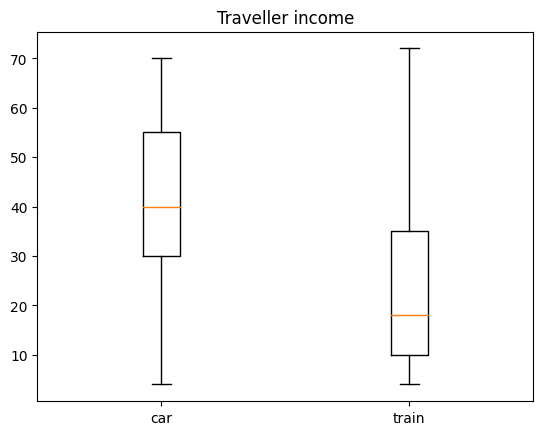

In [5]:
plt.figure()
plt.boxplot(x = grouped_values["income"],
           labels = unique_vehicles)
plt.title("Traveller income")
plt.show()

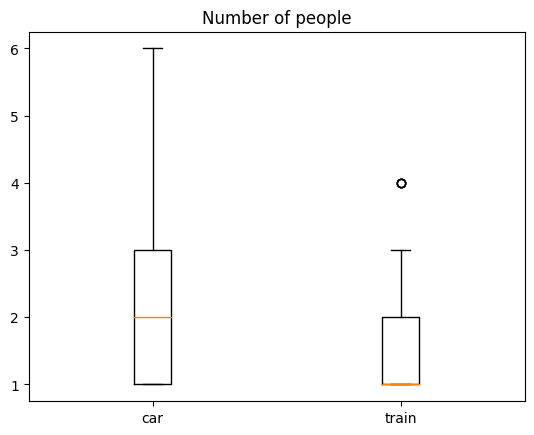

In [6]:
plt.figure()
plt.boxplot(x = grouped_values["num_people"],
           labels = unique_vehicles)
plt.title("Number of people")
plt.show()

## Logistic model

### Question

Fit a logistic regression model to this data. Do the estimated coefficients make
sense?

[hint](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.logit.html#statsmodels.formula.api.logit)

### Answer

We can use the `logit` function from `smf` to fit the logistic regression.

In [7]:
logistic_model = smf.logit(formula="is_car ~ income + num_people", data = cb_df).fit()

Optimization terminated successfully.
         Current function value: 0.560467
         Iterations 6


In [8]:
logistic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 is_car   No. Observations:                  122
Model:                          Logit   Df Residuals:                      119
Method:                           MLE   Df Model:                            2
Date:                Wed, 30 Nov 2022   Pseudo R-squ.:                  0.1908
Time:                        11:06:44   Log-Likelihood:                -68.377
converged:                       True   LL-Null:                       -84.498
Covariance Type:            nonrobust   LLR p-value:                 9.968e-08
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2289      0.523     -4.263      0.000      -3.254      -1.204
income         0.0566      0.013      4.399      0.000       0.031       0.082
num_people     0.1885      0.201      0.936      0.349      -0.206       0.583
==============================================================================
"""

### Question

Write a function called `logit` which computes the logit function and
`inv_logit` which computes its inverse.

[hint](https://en.wikipedia.org/wiki/Logit#Definition)

### Answer

In [9]:
def logit(p):
    return np.log(p / (1 - p))

def inv_logit(a):
    return np.exp(a) / (np.exp(a) + 1)

The following snippet demonstrates one way to visualise the results of the model
fit. If you have defined `logit` and `inv_logit` above this should make a
sensible figure.

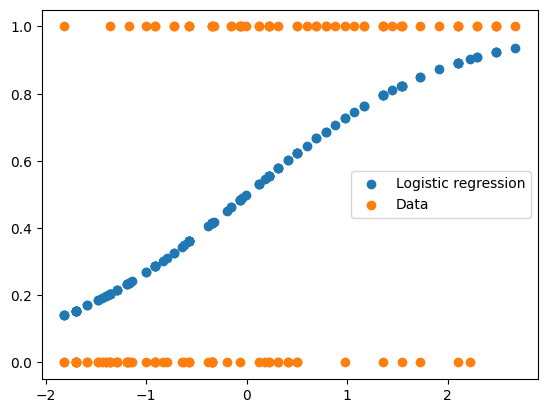

In [10]:
prob_is_car = logistic_model.predict()
log_odds_is_car = logit(prob_is_car)

plt.figure()
plt.scatter(log_odds_is_car, prob_is_car, label="Logistic regression")
plt.scatter(log_odds_is_car, cb_df["is_car"], label = "Data")
plt.legend()
plt.show()

### Question

For a fixed income, what change does the model predict for each additional
person on the journey? What happens to the log-odds for each additional person?
What happens to the odds?

### Answer

$$
\ln\left(\frac{p}{1-p}\right) = -2.2 + 0.06 \times \text{income} + 0.19 \times\text{num_people}
$$

For each additional person the *log-odds* of going by car increases by 0.19.

$$
\frac{p}{1-p} = e^{-2.2} (e^{0.06})^{\text{income}} + (e^{0.19})^{\text{num_people}}
$$

For each additional person the *odds* of going by car increase but the change is
not as simple as in the case of the log-odds.

### Question

For journeys with 2 people, plot the probability of going by car (as opposed to
train) as a function of household income. Determine the level of income at which
it becomes more likely they will travel by car than train.

### Answer

We can evaluate the predicted probability at a range of income levels and then
read off the plot that this changes at about 32.7 thousand, or we can just solve
for this value using the expression in the snippet.

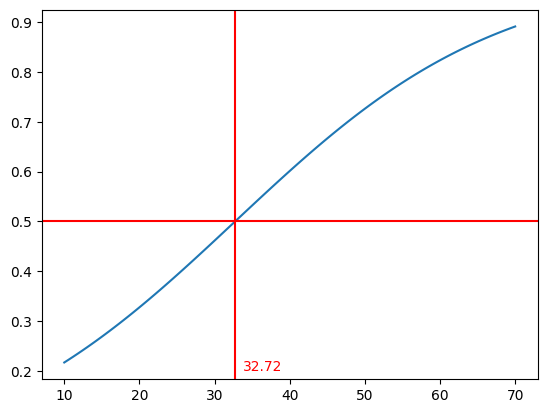

In [11]:
income_change_point = (2.23 - 0.189 * 2) / 0.0566
income_vals = np.linspace(10, 70, 100)

theta_int = logistic_model.params.Intercept
theta_income = logistic_model.params.income
theta_num = logistic_model.params.num_people

prob_car = inv_logit(theta_int + theta_income * income_vals + theta_num * 2)

plt.figure()
plt.plot(income_vals, prob_car)
plt.axhline(0.5, color='r')
plt.axvline(income_change_point, color='r')
plt.annotate("{x:.2f}".format(x=income_change_point), (income_change_point + 1, 0.2), color='r')
plt.show()

### Question

Plot the probability of going by car for 1, 2, and 3 people as a function of
income. What do you notice about the change in the probability as a function of
income?

### Answer

The change in probability is non-linear and depends upon the other variables,
but it is increasing with the number of people.

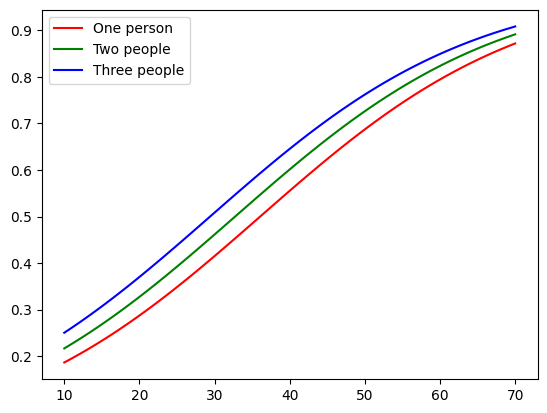

In [12]:
income_vals = np.linspace(10, 70, 100)

theta_int = logistic_model.params.Intercept
theta_income = logistic_model.params.income
theta_num = logistic_model.params.num_people

prob_car_fn = lambda n : inv_logit(theta_int + theta_income * income_vals + theta_num * n)

plt.figure()
plt.plot(income_vals, prob_car_fn(1), color='r', label='One person')
plt.plot(income_vals, prob_car_fn(2), color='g', label='Two people')
plt.plot(income_vals, prob_car_fn(3), color='b', label='Three people')
plt.legend(loc='upper left')
plt.show()

## Bonus Example: Multinomial logistic regression

### Question

Set up a multinomial logistic regression model to predict the mode of transport
used based on all of the data.

### Answer

In [13]:
all_df = travel_df[travel_df["choice"] == "yes"]
all_df = all_df[["mode", "income", "size"]]
all_df = all_df.rename(columns={"mode": "vehicle", "size": "num_people"})

all_df["vehicle_int"] = 0
all_df.loc[all_df["vehicle"] == "air","vehicle_int"] = 1
all_df.loc[all_df["vehicle"] == "bus","vehicle_int"] = 2
all_df.loc[all_df["vehicle"] == "car","vehicle_int"] = 3
all_df.loc[all_df["vehicle"] == "train","vehicle_int"] = 4
all_df.vehicle.value_counts()

train    63
car      59
air      58
bus      30
Name: vehicle, dtype: int64

In [14]:
multi_logistic = smf.mnlogit(formula = "vehicle_int ~ income + num_people", data = all_df).fit()
multi_logistic.summary()

Optimization terminated successfully.
         Current function value: 1.206385
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:            vehicle_int   No. Observations:                  210
Model:                        MNLogit   Df Residuals:                      201
Method:                           MLE   Df Model:                            6
Date:                Wed, 30 Nov 2022   Pseudo R-squ.:                  0.1072
Time:                        11:06:44   Log-Likelihood:                -253.34
converged:                       True   LL-Null:                       -283.76
Covariance Type:            nonrobust   LLR p-value:                 3.044e-11
=================================================================================
vehicle_int=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.0345      0.651      1.588      0.112      -0.242       2.311
income           -0.0339      0.013     -2.618      0.009      -0.059      -0.009
num_people       -0.3399      0.337     -1.009      0.313      -1.000       0.320
---------------------------------------------------------------------------------
vehicle_int=3       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.9435      0.550     -1.716      0.086      -2.021       0.134
income           -0.0035      0.010     -0.344      0.731      -0.024       0.017
num_people        0.6006      0.199      3.015      0.003       0.210       0.991
---------------------------------------------------------------------------------
vehicle_int=4       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.5504      0.520      2.983      0.003       0.532       2.569
income           -0.0609      0.012     -5.139      0.000      -0.084      -0.038
num_people        0.2907      0.226      1.288      0.198      -0.152       0.733
=================================================================================
"""